<img align="left" src="./logo.png" width=300>

# `Phaser`: BCDI Phase retrieval in Python

## Created by: Siddharth Maddali
### Argonne National Laboratory
<a href="https://doi.org/10.5281/zenodo.4305131" style="float: left;"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.4305131.svg" alt="DOI"></a>

# Initial setup

In [1]:
import numpy as np

# import custom modules
import Phaser as ph
import ExperimentalGeometry as exp # currently implements the motors at 34-ID-C
import TilePlot as tp
import PlotLikeMatlab as plm

# plotting 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


# Module to read Matlab .mat files
import scipy.io as sio

In [2]:
# 'inline': non-interactive plot
# 'notebook': interactive plot (Jupyter notebook)
# 'widget': interactive plot (Jupyter lab)
%matplotlib inline

## Loading data set into Python

In [3]:
dataset = sio.loadmat( 'data.mat' )
print( dataset.keys() )
    # NOTE: if you opened this file in Matlab,
    # you'd see only the 'data' variable in the workspace.
    
data = dataset[ 'intens_coherent' ] # the 3D data is now a numpy array.
data = np.random.poisson( 3.e4 * data / data.max() )
print( 'Array size = ', data.shape )

dict_keys(['__header__', '__version__', '__globals__', 'crystal_4', 'intens_coherent', 'intens_partcoh', 'signal', 'pcc_parameters', 'covariance_matrix'])
Array size =  (128, 128, 70)


## Pre-processing the dataset

Assumes that the following are already done:
   1. Stray scattering removed
   1. White-field correction done
   1. Background/hot pixels taken care of

In [4]:
# If necessary, trim the dataset to even dimensions 
# by removing the last image in the stack. Typically 
# this is not necessary for in-plane dimensions since 
# detectors are usually even-pixeled.

# data = data[:,:,:-1]
print( 'Array size = ', data.shape )

maxHere = [ n[0] for n in np.where( data==data.max() ) ]
print( 'Bragg peak initially at: ', maxHere )

# Now centering Bragg peak in the array. If this is not done, you will see 
# a phase ramp in the final reconstruction.
for n in [ 0, 1, 2 ]: 
    data = np.roll( data, data.shape[n]//2 - maxHere[n], axis=n )
    
maxHereNow = [ n[0] for n in np.where( data==data.max() ) ]
print( 'Bragg peak now at: ', maxHereNow )

Array size =  (128, 128, 70)
Bragg peak initially at:  [64, 64, 35]
Bragg peak now at:  [64, 64, 35]


## Creating initial support for phase retrieval
   - This gets updated with a shrinkwrap algorithm
   - Initial support should never be bigger than half of the array size along each axis.

In [5]:
shp = data.shape
supInit = np.zeros( shp )
supInit[ #   // means integer division in Python3, as opposed to /, the usual floating point division
    ( shp[0]//2 - shp[0]//6 ):( shp[0]//2 + shp[0]//6 ), 
    ( shp[1]//2 - shp[1]//6 ):( shp[1]//2 + shp[1]//6 ), 
    ( shp[2]//2 - shp[2]//6 ):( shp[2]//2 + shp[2]//6 )
] = 1.

# CPU tutorial 
## Create a phase retrieval solver object for CPU

In [6]:
PR = ph.Phaser( modulus=np.sqrt( data ) ) # support initialized inside

## Shrinkwrap
Implemented in the method `PR.Shrinkwrap( sigma, thresh )`. 
   - Object modulus is convolved with a Gaussian (std deviation `sigma`)
   - Thresholded to fraction `thresh` of the maximum value.

## Example recipe for phase retrieval
   - 150 iterations of error reduction (ER), with support-updating every 30 iterations
   - 300 iterations of hybrid input-output (HIO)
   - 100 iterations of solvent-flipping (SF) with support-update every 25 iterations
   - 300 iterations of hybrid input-output (HIO)
   - 450 iterations of ER again, with support-updating every 90 iterations

In [7]:
sigma = np.linspace( 5., 3., 5 )    #
for sig in sigma:                   #  150 iters. of error reduction
    PR.ER( 30, show_progress=True ) #  with shrinkwrap every 30 iters.
    PR.Shrinkwrap( sig, 0.1 )       #
    
PR.HIO( 300, show_progress=True )   #  300 iterations of hybrid I/O

sigma = np.linspace( 3., 2., 4 )
for sig in sigma:                   #
    PR.SF( 25, show_progress=True ) #  100 iterations of solvent flipping, 
    PR.Shrinkwrap( sig, 0.1 )       #  shrinkwrap every 25 iterations.
    
PR.HIO( 300, show_progress=True )   #  300 iterations of hybrid I/O

sigma = np.linspace( 2., 1., 5 )
for sig in sigma:                   #
    PR.ER( 90, show_progress=True ) #  450 iterations of error reduction, 
    PR.Shrinkwrap( sig, 0.1 )       #  shrinkwrap every 90 iterations.

 ER: 100%|██████████| 90/90 [00:15<00:00,  5.87it/s]


## Extracting image and support from black box

In [8]:
PR.Retrieve() # centers the compact object in array, and smooths it
img = PR.finalImage
sup = PR.finalSupport

## Visualizing the result

### Scatterer amplitude

Text(0.5, 409.19735294117646, 'XY')

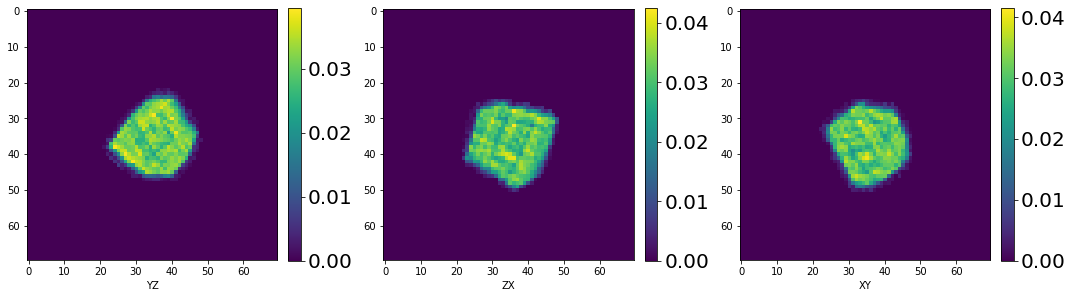

In [9]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.absolute( img[64,29:99,:] ), 
        np.absolute( img[29:99,64,:] ), 
        np.absolute( img[29:99,29:99,35] )                                         
    ),
    ( 1, 3 )
)

ax[0].set_xlabel( 'YZ' )
ax[1].set_xlabel( 'ZX' )
ax[2].set_xlabel( 'XY' )

# fig.savefig( 'images/scattererAmp.jpg' )

### Scatterer support

Text(0.5, 409.19735294117646, 'XY')

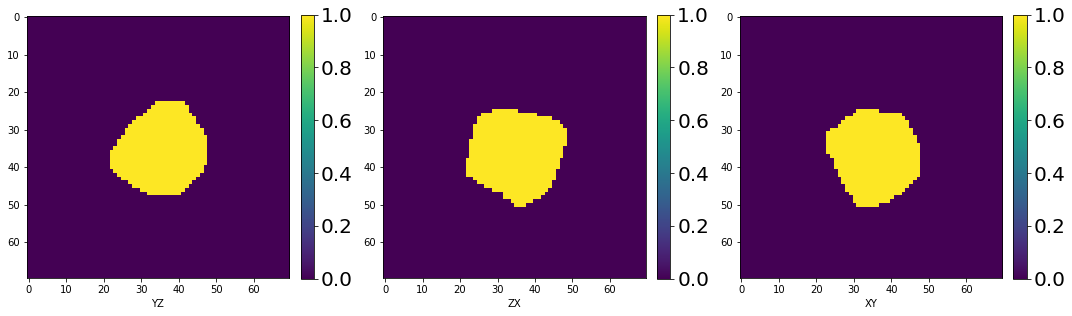

In [10]:
fig, im, ax = tp.TilePlot( 
    ( 
        sup[64,29:99,:], 
        sup[29:99,64,:], 
        sup[29:99,29:99,35]                                         
    ),
    ( 1, 3 )
)

ax[0].set_xlabel( 'YZ' )
ax[1].set_xlabel( 'ZX' )
ax[2].set_xlabel( 'XY' )

# fig.savefig( 'images/scattererSup.jpg')

### Scatterer phase

Text(0.5, 409.19735294117646, 'XY')

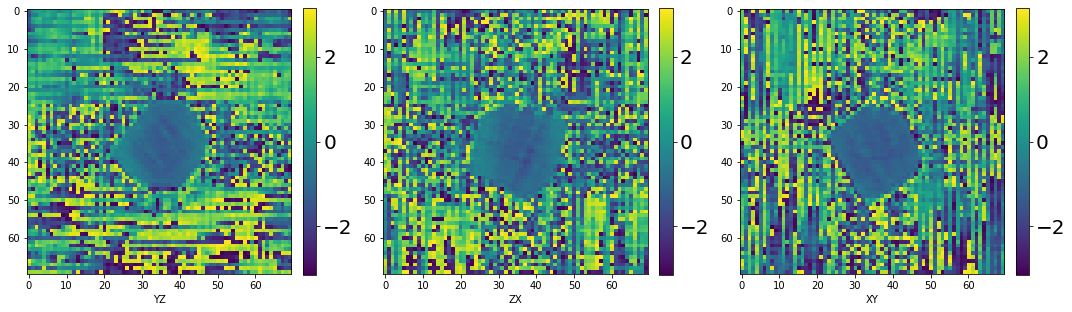

In [11]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.angle( img[64,29:99,:] ), 
        np.angle( img[29:99,64,:] ), 
        np.angle( img[29:99,29:99,35] )                                         
    ),
    ( 1, 3 )
)

ax[0].set_xlabel( 'YZ' )
ax[1].set_xlabel( 'ZX' )
ax[2].set_xlabel( 'XY' )

# fig.savefig( 'images/scattererPh.jpg' )

### Reconstruction error

Text(0, 0.5, 'Error')

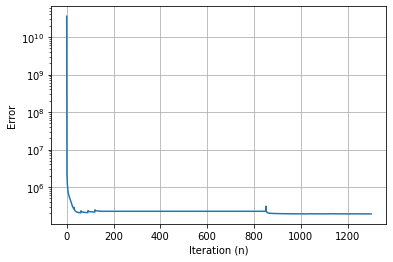

In [12]:
plt.figure()
plt.semilogy( PR.Error() )
plt.grid()
plt.xlabel( 'Iteration (n)' )
plt.ylabel( 'Error' )

# plt.savefig( 'images/reconErr.jpg' )

# Isosurface plotting
After the recipe has run and the object array is retrieved as shown above, its isosurface can be plotted with Matlab-like Python functions defined in the `PlotLikeMatlab` module. 
Any 3D rendering in Bragg phase retrieval should be aware of the sampling step sizes and directions in real space, that are implied by each of the three dimensions of the 
The `ExperimentalGeometry` module is needed to correctly resolve the 3D rendering of the object. 

For the purpose of demonstration, the phased object obtained above is assigned arbitrary experimental parameters below. 
In reality, these have to match the actual scan parameters from the measurement.
This example is customized to the 34-ID-C experimental end station at the Adcanced Photon Source.

In [13]:
params = { # these are 34-ID-C parameters
    'lam':1.378e-10, # wavelength in meters
    'pix':55.e-6, # pixel pitch, meters
    'arm':0.65, # sample-detector distance, meters
    'gamma':45., # elevation, degrees
    'delta':25., # azimuth, dgrees
    'dtheta':0.01, # rocking step, degrees
    'recipSpaceSteps':shp # object dimensions, pixels
}
geom = exp.ScatteringGeometry( **params )
Bdet = geom.detectorFrame
Breal, Brecip = tuple( Bdet.T @ this for this in geom.getSamplingBases() )
    # real-space and Fourier-space sampling bases are now in the detector frame

In [14]:
colorbar = {
    'title':'Phase (rad)', 
    'vertical':True, 
    'interactive':True, 
    'label_font_size':20, 
    'title_font_size':25, 
    'font_family':'times', 
    'color':[ 0., 0., 0. ]
}

isol = plm.isosurface( 
    data=img, 
#     data=np.conj( np.flip( img, axis=[ 0, 1, 2 ] ) ), # use this for the mirror twin solution
    isoval=0.5,
    Br=Breal, 
    colorbar=colorbar
)
isol.set_background( [ 0.5, 0.5, 0.5 ] )
# plm.savefig3d( isol, 'images/isol' ) # saves as pdf

## Phased object: isosurface

<img src="images/isol.png" width=600>

Note the different shape of the object above, compared to the pixelated reconstructions. 
This is simply a demonstration in the use of `Breal`. 
In a reconstruction with real-world data, a similar isosurface with the properly calculated `Breal` is guaranteed to be rendered correctly.

# Recipe strings

`Phaser` can also run an entire phase retrieval recipe by parsing "recipe strings", which are simply Python strings that encode a phase retrieval recipe. 
See `RecipeParser.py` documentation for more details.

   - Recipe string for 30 iterations of ER is simply:<br/>`'ER:30'`.  
   
   - Recipe string for 100 ER followed by 25 HIO, followed by 40 SF:<br/>`'ER:100+HIO:25+SF:40'`
   
   - Shrinkwrap recipe string format:<br/>`'SR:<sigma>:<thresh>'`

## Generating the recipe string for the CPU recipe above

In [15]:
recipestr1 = '+'.join( [ 'ER:30+SR:%.2f:0.1'%sig for sig in np.linspace( 5., 3., 5 ) ] )
recipestr2 = '+'.join( [ 'SF:25+SR:%.2f:0.1'%sig for sig in np.linspace( 3., 2., 4 ) ] )
recipestr3 = '+'.join( [ 'ER:90+SR:%.2f:0.1'%sig for sig in np.linspace( 2., 1., 5 ) ] )
recipestr = '+HIO:300+'.join( [ recipestr1, recipestr2, recipestr3 ] )
print( recipestr )

ER:30+SR:5.00:0.1+ER:30+SR:4.50:0.1+ER:30+SR:4.00:0.1+ER:30+SR:3.50:0.1+ER:30+SR:3.00:0.1+HIO:300+SF:25+SR:3.00:0.1+SF:25+SR:2.67:0.1+SF:25+SR:2.33:0.1+SF:25+SR:2.00:0.1+HIO:300+ER:90+SR:2.00:0.1+ER:90+SR:1.75:0.1+ER:90+SR:1.50:0.1+ER:90+SR:1.25:0.1+ER:90+SR:1.00:0.1


## Running the recipe using the string

Here, starting with a new `Phaser` object and use the `runRecipe` method...

In [16]:
PR_alt = ph.Phaser( modulus=np.sqrt( data ) )
PR_alt.runRecipe( recipestr, show_progress=True )
PR.Retrieve() 
img = PR.finalImage
sup = PR.finalSupport

 ER: 100%|██████████| 90/90 [00:15<00:00,  5.85it/s]


... and so on, to get the same result!

   - Recipe strings can be used in parallelized phase retrieval.
   - Disabling the progress bars in the above example (`show_progress=False`) will likely speed up the whole recipe.
   - Recipe strings can work with CPU as well as GPU without loss of generality.

# GPU tutorial

In [17]:
PR2 = ph.Phaser( modulus=np.sqrt( data ), gpu=True ).gpusolver

## Recipe for GPU phase retrieval (identical to earlier CPU recipe)
   Notice how **obscenely faster** the same recipe runs on the GPU!
   In my case, this was a single [**NVidia GeForce GTX 1650**](https://www.nvidia.com/en-us/geforce/graphics-cards/gtx-1650/) with 4 MiB memory.

In [18]:
sigma = np.linspace( 5., 3., 5 )    #
for sig in sigma:                   #  150 iters. of error reduction
    PR2.ER( 30, show_progress=True ) #  with shrinkwrap every 30 iters.
    PR2.Shrinkwrap( sig, 0.1 )       #
    
PR2.HIO( 300, show_progress=True )   #  300 iterations of hybrid I/O

sigma = np.linspace( 3., 2., 4 )
for sig in sigma:                   #
    PR2.SF( 25, show_progress=True ) #  100 iterations of solvent flipping, 
    PR2.Shrinkwrap( sig, 0.1 )       #  shrinkwrap every 25 iterations.
    
PR2.HIO( 300, show_progress=True )   #  300 iterations of hybrid I/O

sigma = np.linspace( 2., 1., 5 )
for sig in sigma:                   #
    PR2.ER( 90, show_progress=True ) #  450 iterations of error reduction, 
    PR2.Shrinkwrap( sig, 0.1 )       #  shrinkwrap every 90 iterations.

 ER: 100%|██████████| 90/90 [00:00<00:00, 330.79it/s]


## Extracting image and support from black box `PR2`
Same way as for the CPU recipe: 
```python
PR2.Retrieve()
img = PR2.finalImage
sup = PR2.finalSupport
```

# Parallelization on CPU/GPU

   - Implemented using MPI bindings for Python (`mpi4py`).
   - Uses recipe strings for efficient parallelization.
   - See Python script `Guided.py` for a basic CPU tutorial and `Guided_GPU.py` for the corresponding GPU tutorial.
   - Usage: 
       - Install `mpi4py`: instructions [here](https://mpi4py.readthedocs.io/en/stable/install.html).
       - Run the script from the Bash (not Python!) command line; for example, to parallelize on 4 processors:
       ```bash
       $ mpirun -n 4 python Guided.py
        ```
   - The genetic algorithms implemented are described in [A. Ulvestad et al. _Sci Rep_ 7, 9920 (2017)](https://doi.org/10.1038/s41598-017-09582-7).

## CAUTION

   1. There seems to be significant overhead introduced when scaling up to multiple processors; this can be offset somewhat by keeping the phase retrieval recipe itself short and simple.

# Partial coherence correction (PCC)
For a partially coherent beam, Phaser allows for an estimate of the partial coherence function (PCF) in addition to executing the recipe.
The PCF is modeled as a 6-parameter Gaussian blurring function in 3D (based on the analysis presented in [Maddali et al., _Phys. Rev. Applied_ **14**, 024085 (2020)](https://link.aps.org/doi/10.1103/PhysRevApplied.14.024085)). 
The inferred diffraction signal is obtained by convolving the coherent diffraction intensity with the PCF.

Currently the partial coherence correction is implemented only on the GPU.
A synthetic partially coherent dataset is generated and reconstructed for this demonstration. 

## PCC implementation

A full tutorial is available [here](https://nbviewer.jupyter.org/github/siddharth-maddali/Phaser/blob/master/partial_coherence.ipynb). 

# Acknowledgements

   - **Matthew Wilkin** (Dept. of Materials Science and Engg., Carnegie Mellon University) <br/>
   for finding bugs through continued usage and even fixing them.